# Absorption Spectroscopy from Molecular Dynamics

With the formulas developed in the last lecture, we're finally ready to simulate real spectroscopic data! In this exercise, we'll simulate the reponse of a small ensemble of diatomic molecules to a perturbing laser field, calculate the polarization, and transform to obtain an absorption spectrum. 

In order to speed up the simulations, the simulation code has been updated in two ways:
* **Inter-molecular interactions** have been turned **off**. The particle charges are allowed to interact with the electric field, but not with each other. This assumption is often quite realistic for dilute solutions, although in our simulation it is somewhat artificial since (to keep the particles visible) we've squeezed them into a very small simulation box. 
* **Periodic boundary conditions** have been imposed to avoid the need for particles to interact with the walls of the box. When a molecule drifts outside of one side of the box it immediately "pops" back into the other side. This is in fact the type of simulation box used in most MD methods. 

With these modifications, our code executes much faster than in previous exercises, so that we can handle several hundred particles at once. This better averaging is critical for accurately reproducing the physical features of a thermodynamic ensemble and, in particular, for limiting noise in our polarization time traces and absorption spectra. 

## Instructions

The app below has controls similar to those from last week, but also includes an entry box for a file name. When the code is executed the time axis, field time trace, and polarization time trace generated in the simulation will be automatically written to this file. After you've explored the simulation a bit, generate an exercise submission file for yourself using the "Copy Exercise" button at the bottom of the file, and follow the instructions in the text. For each simulation you're instructed to run in the exercise file, be sure to save your simulation data under a unique file name so that you can load it into your submission code. 

For your homework submission, submit both the ipynb file **and** the text files that store your simulation data. Without the text files I won't be able to run your code!

In [1]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets

import numpy as np

from IPython.display import Javascript, display
from ipywidgets import widgets
import IPython.display as ipd



def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

gamma_slider = widgets.FloatSlider(
    value=50,
    min=0,
    max=150,
    step=1.0,
    description='$\gamma$ (pg/s):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
    
temp_slider = widgets.FloatSlider(
    value=300,
    min=0,
    max=1000,
    step=1.0,
    description='T (K):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

emax_slider = widgets.FloatSlider(
    value=100,
    min=0,
    max=250,
    step=1.0,
    description='$E_{max}\cdot 10^{-4}$ (statV/cm):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tmax_slider = widgets.FloatSlider(
    value=3,
    min=0,
    max=10,
    step=1.0,
    description='$t_{max}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tpulse_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=10,
    step=0.5,
    description='$t_{pulse}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

taupulse_slider = widgets.FloatSlider(
    value=20,
    min=10,
    max=1000,
    step=0.5,
    description='$\\tau_{pulse}$ (fs)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

vpulse_slider = widgets.FloatSlider(
    value=4.0,
    min=0,
    max=100,
    step=0.1,
    description='$\\nu_{pulse}$ (THz)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)



nmol_slider = widgets.IntSlider(
    value=15,
    min=1,
    max=500,
    step=1,
    description='N$_{mol}$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

skip_box = widgets.Checkbox(
    value = True,
    description = 'Skip frames?'
)

txt_fname = widgets.Text(
    value='test.txt',
    placeholder='test.txt',
    description='Output File:',
    disabled=False
)

button = widgets.Button(description="Go!")
button.on_click(run_all)

pulse_box = widgets.VBox([tpulse_slider, taupulse_slider, vpulse_slider, emax_slider])
part_box = widgets.VBox([nmol_slider, tmax_slider, gamma_slider, temp_slider])

display(widgets.HBox([pulse_box, part_box]))
display(skip_box)
display(button)
display(txt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checkbox(value=True, description='Skip frames?')

Button(description='Go!', style=ButtonStyle())

Text(value='test.txt', description='Output File:', placeholder='test.txt')

In [2]:
gamma = gamma_slider.value*1e-12  # grams/second
Temp = temp_slider.value          # K
Emax = emax_slider.value*1e+4   # Maximum electric field in statV/cm
tmax = tmax_slider.value*1e-12      # Total simulation time in seconds
tpulse = tpulse_slider.value*1e-12      # Pulse arrival time in seconds
tau_pulse = taupulse_slider.value*1e-15  # Pulse width (std. dev.) in seconds
Nmol = nmol_slider.value
dt=0.5e-15     # Time-step in seconds
tmax = tmax_slider.value*1e-12
ofname = txt_fname.value

vpulse = vpulse_slider.value*1e+12                      # pulse frequency in Hz
skip_frames = skip_box.value

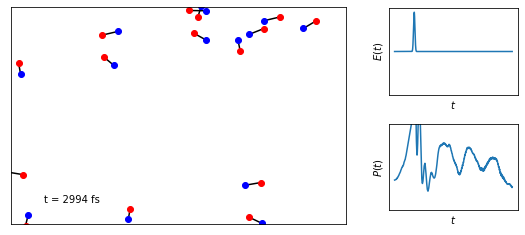

In [3]:
def calc_accel(x,y,efield):
    Minv = 1/M
    ax = np.zeros(np.shape(x))
    ay = np.zeros(np.shape(y))

    # X differences: Rx[m,n] is the x-displacement between particles m and n
    Rx = x - x.transpose()
    
    # Y differences: Ry[m,n] is the y-displacement between particles m and n
    Ry = y - y.transpose()
    
    dX = np.diag(Rx[0:Npos,Npos:])
    dY = np.diag(Ry[0:Npos,Npos:])
    dR = np.sqrt(np.power(dX,2) + np.power(dY,2))
    
    ax[0:Npos,:] -= np.reshape(K*Minv*(dR-Rbond)*(dX/dR), (Npos,1))
    ay[0:Npos,:] -= np.reshape(K*Minv*(dR-Rbond)*(dY/dR), (Npos,1))
    
    ax[Npos:,:] += np.reshape(K*Minv*(dR-Rbond)*(dX/dR), (Npos,1))
    ay[Npos:,:] += np.reshape(K*Minv*(dR-Rbond)*(dY/dR), (Npos,1))
    
    ay += np.reshape(Q*efield*Minv, (Npart,1))
    return ax,ay
    
def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    ynew = y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    
    # If the COM for a molecule has drifted out of the box, we want to move
    # the whole molecule back. The COM for each particle's molecule is 
    comx = 0.5*(x + np.fft.fftshift(x))
    comy = 0.5*(y + np.fft.fftshift(y))
    
    # Now if com < L we add L. If com>L, we subtract L:
    ynew += (comy<0)*L - (comy>L)*L
    xnew += (comx<0)*L - (comx>L)*L

    return xnew,ynew,vxnew,vynew,axnew,aynew

##############################
##############################

def init_plot():
    
    fig = plt.figure(1)
    ax1 = plt.gca()
    
    bondLines = []
    for m in range(0, Nmol):
        bondLine, = plt.plot([X[m],X[Npos+m]], [Y[m],Y[Npos+m]],'k-')
        bondLines.append(bondLine)
        
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    
    
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([])
    plt.yticks([])
    
    ax2 = plt.axes([1.0,0.575,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1.1,1.1])
#     plt.ylim([0,dt*Nsteps])
    
    ax3 = plt.axes([1.0,0.175,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$P(t)$')
    pol_line, = plt.plot(taxis,Pol)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1,1])
    
    return fig,ax1,ax2,ax3,negLine,posLine,txt,field_line,pol_line,bondLines

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    for m in range(0, Nmol):
        bondLines[m].set_xdata([X[m],X[Npos+m]])
        bondLines[m].set_ydata([Y[m],Y[Npos+m]])
    
    plt.sca(ax2)
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
    
    plt.sca(ax3)
    pol_line.set_xdata(taxis[0:n])
    pol_line.set_ydata(Pol[0:n])
    
    fig.canvas.draw()
    display(plt.gcf())
    ipd.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)*0.01
Ro = 10.0e-8

L = 0.25e-6
to = tpulse
sigma = tau_pulse
nu = vpulse


Nsteps=int(round(tmax/dt))
M=12*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)

#####################################################
######### Constants for Langevin integrator #########
#####################################################

kB = 1.38064852e-16                  # erg/K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

#####################################################
#####################################################

# Set Particle charges
Npart = 2*Nmol

# One positive particle per molecule
Npos = Nmol
Q = np.zeros((Npart))  # Empty vector for particle charges
Q[0:Npos] = +Qo    # First Npos particles are positive
Q[Npos:] = -Qo     # Last Nneg particles are negative

# QQ is an (Npart)x(Npart) matrix where QQ[m,n] is the 
# *product* of the charges on particles m and n
QQ = np.reshape(Q, (Npart,1))@np.reshape(Q, (1,Npart))

# Set QQ elements that correspond to intermolecular bonds to zero
np.fill_diagonal(QQ[0:Npos,Npos:].view(), 0)
np.fill_diagonal(QQ[Npos:,0:Npos].view(), 0)


# Set initial velocities to zero 
VX = np.zeros((Npart,1))
VY = np.zeros((Npart,1))

# Generate the pulse profile
Efield = gauss_pulse(taxis)

Rbond = 1.24e-8
wo = 6.28*35e12        # Oscillator (angular) frequency
K = M*wo**2

AX = 1e+50
AY = 1e+50
# while max(np.max(np.abs(AX)), np.max(np.abs(AY)))>1.0e+22:

# Generate a vector of random *molecular* positions
Rx = np.random.random((Nmol))*L
Ry = np.random.random((Nmol))*L

# Generate random orientations between 0 and 2*pi radians
Theta = np.random.random((Nmol))*2.0*math.pi

# Generate positions for positive and negative atoms in each molecule
# Note: X[n] and X[n+Npos] are bonded pairs! (Same with Y[n] and Y[n+Npos].)
X = np.concatenate((Rx+0.5*Rbond*np.cos(Theta),Rx-0.5*Rbond*np.cos(Theta)))
Y = np.concatenate((Ry+0.5*Rbond*np.sin(Theta),Ry-0.5*Rbond*np.sin(Theta)))
X.shape = (Npart,1)
Y.shape = (Npart,1)

# Calculate accelerations at initial positions
AX,AY = calc_accel(X,Y,Efield[0])

if skip_frames:
    UpdateFreq = 499
else:
    UpdateFreq = 20
    
Pol = np.zeros(np.shape(Efield))
fig,ax1,ax2,ax3,negPts,posPts,txt,field_line,pol_line,bondLines = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    Pol[n] = 25*np.mean(Q*np.reshape(Y-0.5*L,(Npart,)))/(4*Qo*Rbond)
    if(n%UpdateFreq==0):
        update_plot(n)
        
np.savetxt("../../../../local/" + ofname, np.vstack([taxis, Efield.T/np.max(Efield), Pol.T/np.max(Pol)]).T)